# Capstone 2

Andri Rifky 
JCDS1804

# 1. Pendahuluan

## 1.1 Latar belakang 
Kumpulan laporan atau aduan dari penumpang yang diterima oleh TSA (Transport security administration). TSA adalah lembaga keamanan transportasi amerika serikat yang didirikan pada 19 november 2001, alasan dibuat lembaga ini adalah agar tidak terulang kejadian '9/11'.
dalam dataset set ini rentang laporan dari tahun 2002 hingga 2014.

## 1.2 Pernyataan masalah
 1. Pengaduan apa yang sering muncul
 1. Adakah faktor yang mempengaruhi keputusan TSA

# 2. Data preparation

## 2.1 Data Understanding

In [1]:
import matplotlib.pyplot as mpl
import seaborn as snis
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import re
import plotly.express as px
import plotly.graph_objects as go

In [49]:
# Import data
df=pd.read_csv('tsa_claims.csv')
df.head()

C:\Users\andri\AppData\Local\Temp\ipykernel_7388\3850143854.py:2: DtypeWarning: Columns (0,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('tsa_claims.csv')


,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full


In [50]:
df.isna().sum()

Claim Number         0
Date Received      263
Incident Date     2183
Airport Code      8524
Airport Name      8524
Airline Name     34374
Claim Type        7913
Claim Site         740
Item              3966
Claim Amount      4043
Status               5
Close Amount     68952
Disposition      72908
dtype: int64

Ada 13 kolom yang berisi
1. Claim Number: Nomor aduan
1. Date Received: Tanggal laporan diterima
1. Incident Date: Tanggal kejadian
1. Airport Code: Kode bandara
1. Airport Name: Nama bandara
1. Airline Name: Nama maskapai penerbangan
1. Claim Type  : Tipe pengaduan
1. Claim Site  : Lokasi kejadian
1. Item        : Barang yang dilaporkan
1. Claim Amount: Jumlah kehilangan
1. Status      : Keputusan Akhir dari TSA
1. Close Amount: Nilai yang diganti
1. Dispositon  : Keputusan lebih detail 

In [3]:


# Format Kolom agar sedikit rapih
df.columns = [s.strip().replace(' ','_') for s in df.columns]

# Mengubah nama kolom Date
df['Date_Received_String'] = df.Date_Received
df['Incident_Date_String'] = df.Incident_Date
df.drop(['Date_Received','Incident_Date'], axis=1, inplace=True)

print('Rows:', len(df))

Rows: 204267


In [4]:
# Cek Nan per baris
cekna=df.isna().sum(axis=1).value_counts().sort_index()
print ('Nan       Row     Row Kumulatif')
for i in range(len(cekna)):
    print ('{:2d}: {:10d} {:10d}'.format(cekna.index[i], cekna[i], cekna[i:].sum()))

Nan       Row     Row Kumulatif
 0:      94848     204267
 1:      32404     109419
 2:      66106      77015
 3:       4582      10909
 4:       1970       6327
 5:       2253       4357
 6:        977       2104
 7:        321       1127
 8:        634        806
 9:         42        172
10:        106        130
11:         19         24
12:          5          5


ada sekitar 2000 baris data yang memiliki jumlah Nan lebih dari 6, dapat diasumsikan data tersebut memiliki minim informasi

In [5]:
# Cek Nan per kolom
df.isna().sum().sort_values(ascending=False)

Disposition             72908
Close_Amount            68952
Airline_Name            34374
Airport_Code             8524
Airport_Name             8524
Claim_Type               7913
Claim_Amount             4043
Item                     3966
Incident_Date_String     2183
Claim_Site                740
Date_Received_String      263
Status                      5
Claim_Number                0
dtype: int64

* Disposition dan close amount memiliki jumlah Nan paling banyak sekitar 34% dari dataset, kolom ini akan di drop karena bisa diwakilkan dengan kolom lain
* Kolom Nan pada Airline name, Claim Type, dan ,Claim Ammount, bersifat kategorik, maka akan diisi 'other' , 'missing', atau '-'

In [6]:
# Menghapus baris yang memiliki Nan diatas 6
df.dropna(thresh=6, inplace=True)

# Mengisi Nan pada kolom kategorik
isikolom=['Airline_Name','Airport_Name','Airport_Code','Claim_Type','Claim_Site','Item']
df[isikolom] = df[isikolom].fillna('-')

# Mengisi Nan pada kolom Claim Amount menjadi 0
df['Claim_Amount'] = df.Claim_Amount.fillna('$0.00')

print(len(df))


203461


nilai Nan pada kolom date dan status akan di drop berikutnya

### Status

In [7]:
# Cek kolom Status
df.Status.str.split(';').map(lambda x: 'Null' if type(x)==float else x[0]).value_counts()

Denied                                               68336
Approved                                             34997
Deny                                                 28237
Settled                                              27955
-                                                    12752
Approve in Full                                      12364
Canceled                                              6651
Settle                                                5766
Insufficient                                          4972
Closed as a contractor claim                          1312
In litigation                                          108
In review                                                9
Claim has been assigned for further investigation        1
Pending response from claimant                           1
Name: Status, dtype: int64

Kolom status memiliki value yang tidak konsisten (seperti Denied dan Deny) dan bisa digabung (seperti 'Aprrove in full' dapat digabung dengan 'Approved'), kita akan menggabung value kategori tersebut

In [8]:
# Menggabung kategori
valid = ['Denied','Approved','Deny','Settled','Approve in Full', 'Settle']

df = df[df.Status.isin(valid)]
df.Status.replace('Approve in Full','Approved',inplace=True)
df.Status.replace('Deny','Denied',inplace=True)
df.Status.replace('Settle','Settled',inplace=True)

print(df.Status.value_counts())
print(len(df))

Denied      96573
Approved    47361
Settled     33721
Name: Status, dtype: int64
177655


Sisa value yang tidak termasuk kategori diatas otomatis terdrop karena jumlahnya sedikit dan nilai kosong (-)

### Date Received

In [9]:
# Drop Nan pada kolom date receive
df.dropna(subset=['Date_Received_String'], inplace=True)

# Format datetime
df['Date_Received'] = pd.to_datetime(df.Date_Received_String,format='%d-%b-%y')

# Cek range
df = df[df.Date_Received.dt.year.isin(range(2002,2014+1))]

print(df.Date_Received.dt.year.value_counts().sort_index())

2002      782
2003    19367
2004    26621
2005    22494
2006    17662
2007    17383
2008    15253
2009    11598
2010     9729
2011     9795
2012     8891
2013     6233
2014     5118
Name: Date_Received, dtype: int64


### Incident Date
Pada kolom incident date, penulisan tanggal tidak konsisten, ada yang menggunakan formal dd/mm/yyyy 00:00, ada juga yang menggunakan formal dd-mmm-yy. maka akan dirapihkan menjadi 1 format

In [10]:
dict = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}

def format_date(regex, date_string):
    m = regex.match(date_string)
    if(m):
        day, month, year = m.group(1,2,3)
        return '{}/{}/{}'.format(dict[month],day,'20'+year)
    else:
        return date_string

In [11]:
# Drop Nan pada incident date
df.dropna(subset=['Incident_Date_String'], inplace=True)

# Koreksi error pada satu value 
df.Incident_Date_String.replace('6/30/10','06/30/2010 16:30',inplace=True)

# Format agar konsisten
df['Incident_Date_String'] = df.Incident_Date_String.str.replace('-','/')
df['Incident_Date_String'] = df.Incident_Date_String.str.lower()

# Split waktu
df['Incident_Time'] = df.Incident_Date_String.str.split(' ').map(lambda x: x[-1])
df['Incident_Date'] = df.Incident_Date_String.str.split(' ').map(lambda x: x[0])

regex = re.compile(r'/[a-z]{3}/[0-9]{4}')
df = df[df.Incident_Date.map(lambda x: not bool(regex.search(x)))].sort_values(['Date_Received'])

# Format Entry pada tahun 2014
regex = re.compile(r'(\d*)/([a-z]{3})/(1[1-4])$')
df['Incident_Date'] = df.Incident_Date.map(lambda x: format_date(regex,x) )


# Format tanggal, cek range tahun, buat bulan dan tahun
df['Incident_Date'] = pd.to_datetime(df.Incident_Date,format='%m/%d/%Y')
df = df[df.Incident_Date.dt.year.isin(range(2002,2014+1))]

print(df.Incident_Date.dt.year.value_counts().sort_index())
print(len(df))

2002     1631
2003    21859
2004    26166
2005    21209
2006    17436
2007    17076
2008    14776
2009    10080
2010    10879
2011     9848
2012     8755
2013     5999
2014     4293
Name: Incident_Date, dtype: int64
170007


### Airport Code / Name
Penulisan aiport Name beberapa tidak konsisten seperti memiliki spasi berlebih

In [12]:
# Cek banyak nama Airport kemudian digabung menjadi 1 Airport code
temp = df.groupby('Airport_Code').Airport_Name.nunique().sort_values(ascending=False)
print(df[df.Airport_Code.isin(temp[temp>1].index)].groupby('Airport_Code').Airport_Name.unique().head())
print('\n---\n')

# Duplikat untuk spasi berlebih
df['Airport_Code'] = df.Airport_Code.str.strip()
df['Airport_Name'] = df.Airport_Name.str.strip()

# Cek banyak nama Airport kemudian digabung menjadi 1 Airport code
temp = df.groupby('Airport_Code').Airport_Name.nunique().sort_values(ascending=False)
print(df[df.Airport_Code.isin(temp[temp>1].index)].groupby('Airport_Code').Airport_Name.unique().head())

Airport_Code
BOS    [Boston (Logan) International Airport, Boston ...
BUR                                [Bob Hope, Bob Hope ]
DEN    [Denver International Airport, Denver Internat...
DFW    [Dallas-Fort Worth International Airport, Dall...
DUJ    [Dubois Jefferson County, Dubois Jefferson Cou...
Name: Airport_Name, dtype: object

---

Series([], Name: Airport_Name, dtype: object)


Selanjutnya Mengurangi bandara yang memiliki claim kurang dari 200(0.1%)

In [13]:
# melihat distribusi of claims by airport
temp = df.Airport_Code.value_counts()
print('Total: {} airports, {} complaints'.format(temp.count(),temp.sum()))
for num in range(1000,1,-100):
    print('Under {}: {} airports, {} complaints'.format(num, temp[temp<num].count(),temp[temp<num].sum()))

level = 200

Total: 450 airports, 170007 complaints
Under 1000: 407 airports, 42960 complaints
Under 900: 402 airports, 38199 complaints
Under 800: 397 airports, 34015 complaints
Under 700: 392 airports, 30339 complaints
Under 600: 384 airports, 25052 complaints
Under 500: 378 airports, 21592 complaints
Under 400: 372 airports, 18959 complaints
Under 300: 365 airports, 16513 complaints
Under 200: 348 airports, 12258 complaints
Under 100: 307 airports, 6642 complaints


In [14]:
# Set airport dan code to 'Other' dibawah level
def set_other(row, keep_items):
    if row.Airport_Code in keep_items:
        row['Airport_Code_Group'] = row.Airport_Code
        row['Airport_Name_Group'] = row.Airport_Name
    else:
        row['Airport_Code_Group'] = 'Other'
        row['Airport_Name_Group'] = 'Other'
    return row

keep_set = set(temp[temp>=level].index)
df = df.apply(lambda x: set_other(x,keep_set),axis=1)

### Airline Name
Merapihkan nama airline

In [15]:
df['Airline_Name'] = df.Airline_Name.str.strip().str.replace(' ','')
df.Airline_Name.replace('AmericanEagle','AmericanAirlines',inplace=True)
df.Airline_Name.replace('AmericanWest','AmericaWest',inplace=True)
df.Airline_Name.replace('AirTranAirlines(donotuse)','AirTranAirlines',inplace=True)
df.Airline_Name.replace('AeroflotRussianInternational','AeroFlot',inplace=True)
df.Airline_Name.replace('ContinentalExpressInc','ContinentalAirlines',inplace=True)
df.Airline_Name.replace('Delta(Song)','DeltaAirLines',inplace=True)
df.Airline_Name.replace('FrontierAviationInc','FrontierAirlines',inplace=True)
df.Airline_Name.replace('NorthwestInternationalAirwaysLtd','NorthwestAirlines',inplace=True)
df.Airline_Name.replace('SkywestAirlinesAustralia','SkywestAirlinesIncUSA',inplace=True)

df.Airline_Name.value_counts().head(10)
print(len(df))

170007


### Item
mengecek dan merapihkan item

In [16]:
df_item = df.Item.str.split('-').map(lambda x: '' if type(x) == float else x[0])
df_item = df_item.str.split(r' \(').map(lambda x: x[0])
df_item = df_item.str.split(r' &').map(lambda x: x[0])
df_item = df_item.str.split(r'; ').map(lambda x: x[0])
df_item = df_item.str.strip()

categories = df_item.value_counts()


categories[categories > 100]

Other                               32293
Clothing                            20003
Luggage                             17522
Jewelry                             12923
Cameras                             12781
Computer                            11972
Locks                                9724
Cosmetics                            5941
Baggage/Cases/Purses                 5864
                                     5035
Eyeglasses                           3817
Currency                             3168
Travel Accessories                   2884
Cell Phones                          2376
Personal Electronics                 2127
Sporting Equipment                   1700
Personal Accessories                 1500
DVD/CD Players                       1235
MP3 Players                           967
Medicines                             941
Watches                               864
Alcoholic beverages                   772
Food                                  711
Bags                              

### Claim Amount

C:\Users\andri\AppData\Local\Temp\ipykernel_7388\278666181.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Claim_Amount'] = df.Claim_Amount.str.replace(';','').str.replace('$','').str.replace('-','0')


count    1.700070e+05
mean     1.766969e+07
std      7.275922e+09
min      0.000000e+00
25%      2.785500e+01
50%      1.169600e+02
75%      3.500000e+02
max      3.000000e+12
Name: Claim_Value, dtype: float64
Denied      92530
Approved    45096
Settled     32381
Name: Status, dtype: int64
170007


C:\Users\andri\AppData\Local\Temp\ipykernel_7388\278666181.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  snis.distplot(df.Claim_Value[(df.Claim_Value>0)&(df.Claim_Value<500)])


Denied      54939
Approved    44095
Settled     28960
Name: Status, dtype: int64

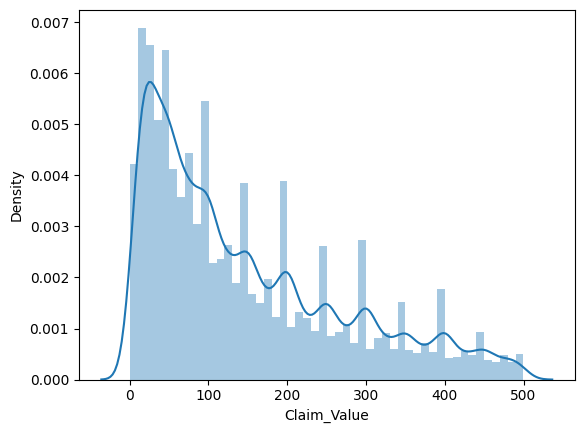

In [17]:
df['Claim_Amount'] = df.Claim_Amount.str.strip()
df['Claim_Amount'] = df.Claim_Amount.str.replace(';','').str.replace('$','').str.replace('-','0')
df['Claim_Value'] = df.Claim_Amount.astype(float)

df_copy = df.copy()

print(df.Claim_Value.describe())
print(df.Status.value_counts())
print(len(df))

snis.distplot(df.Claim_Value[(df.Claim_Value>0)&(df.Claim_Value<500)])

df.Status[(df.Claim_Value>0)&(df.Claim_Value<1000)].value_counts()

kolom claim amount bersifat right skewed, ini dikarenakan kita mengisi nilai Nan dengan 0

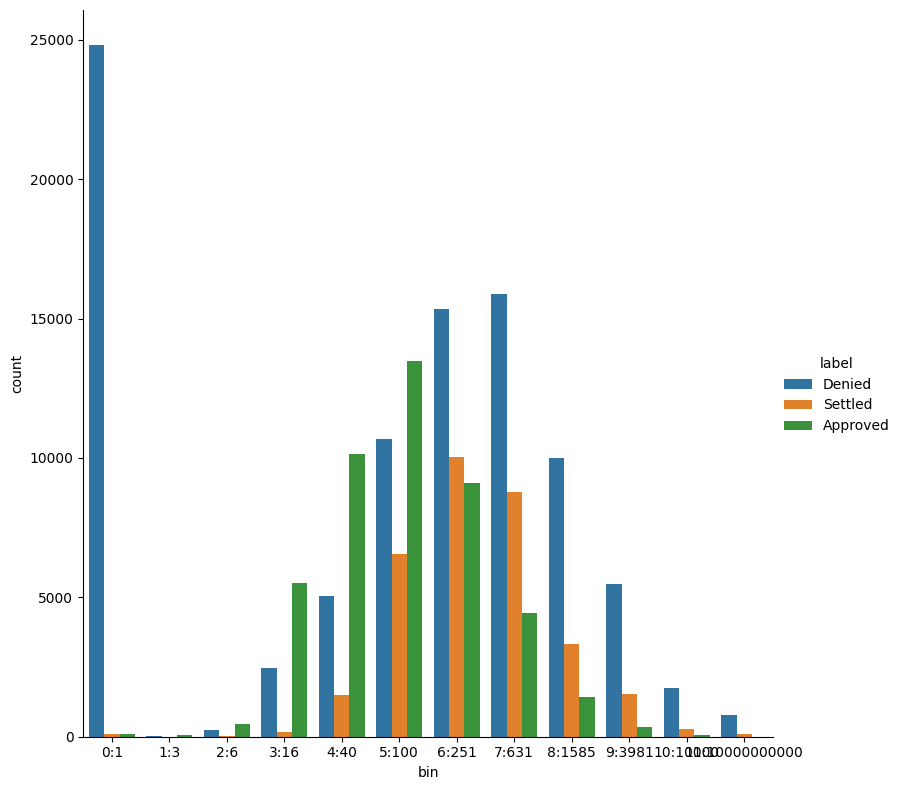

In [18]:
# Grafik claim amount dengan status menggunakan histogram

bins = [round(10**x) for x in (list(np.arange(0,4.1,.4))+[10])]

bottom = -1

data = []

for x,top in enumerate(bins):
    counts = df.Status[(df.Claim_Value>bottom)&(df.Claim_Value<=top)].value_counts()
    for i in range(len(counts)):
        data.append({'bin':(str(x)+':'+str(top)),'label':counts.index[i],'count':counts[i]})
    bottom = top

counts_df = pd.DataFrame(data)

snis.catplot(x='bin',y='count',hue='label',data=counts_df,kind='bar',height=8)

nilai 0 sangat tinggi karena hasil dari Nan, maka nilai 0 kita drop

In [19]:
df = df[df.Claim_Value != 0]

print(df.Claim_Value.describe())
print(df.Status.value_counts())
print(len(df))

count    1.450120e+05
mean     2.071533e+07
std      7.878063e+09
min      4.800000e-01
25%      5.999750e+01
50%      1.599900e+02
75%      4.226500e+02
max      3.000000e+12
Name: Claim_Value, dtype: float64
Denied      67706
Approved    45021
Settled     32285
Name: Status, dtype: int64
145012


### Close amount


In [20]:
# melihat summary data close amount
df['Close_Amount'] = df.Close_Amount.str.strip()
df['Close_Amount'] = df.Close_Amount.str.replace(';','').str.replace('$','')
df['Close_Value'] = df.Close_Amount.astype(float)
df.Close_Value.describe()

C:\Users\andri\AppData\Local\Temp\ipykernel_7388\3930540106.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Close_Amount'] = df.Close_Amount.str.replace(';','').str.replace('$','')


count    128542.000000
mean        101.534805
std         922.714278
min           0.000000
25%           0.000000
50%           0.000000
75%          75.000000
max      250000.000000
Name: Close_Value, dtype: float64

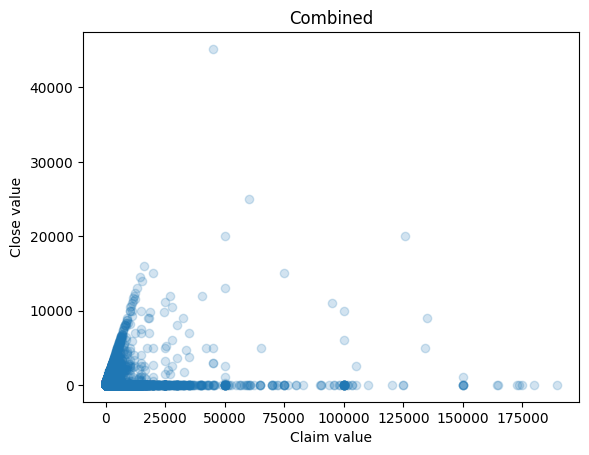

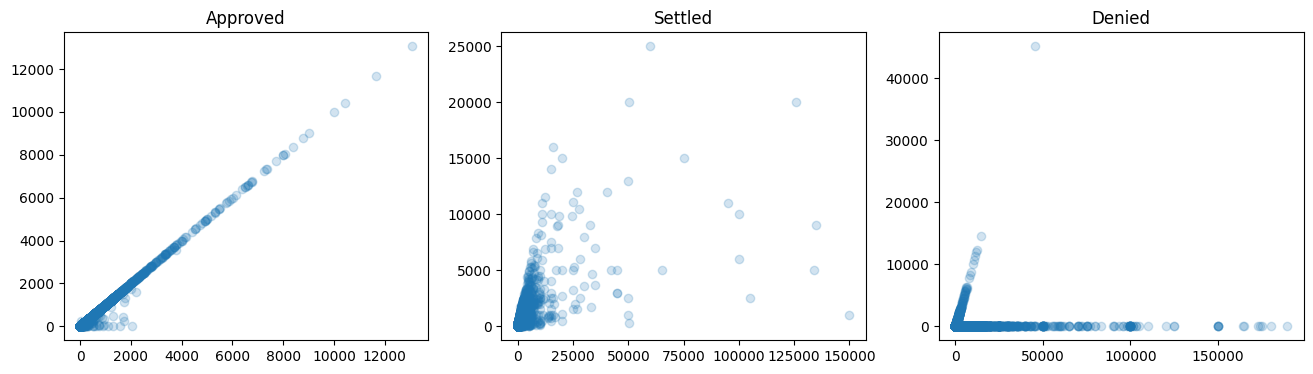

In [21]:
# plotting claim value dan close value dengan scatterplot
plot = df[(df.Claim_Value < 200000) & (df.Close_Value <= 500000)]

mpl.scatter(plot.Claim_Value,plot.Close_Value,alpha=.2)
mpl.title('Combined')
mpl.xlabel('Claim value')
mpl.ylabel('Close value')
mpl.show()

fig,ax = mpl.subplots(1,3)
fig.set_size_inches(16,4)

for i,s in enumerate(plot.Status.unique()):
    ax[i].scatter(plot[plot.Status==s].Claim_Value,plot[plot.Status==s].Close_Value,alpha=.2)
    ax[i].set_title(s)

In [22]:
#Menyimpan data bersih sementara
df_clean = df.drop(['Close_Amount', 'Claim_Amount', 'Disposition',
                     'Date_Received_String','Incident_Date_String','Incident_Time',
                     'Airport_Code','Airport_Name'],axis=1)

df_clean.to_csv('tsa_claims_clean2.csv',index=False)

display(df_clean.head(),df_clean.tail())

,Claim_Number,Airline_Name,Claim_Type,Claim_Site,Item,Status,Date_Received,Incident_Date,Airport_Code_Group,Airport_Name_Group,Claim_Value,Close_Value
0,0909802M,ContinentalAirlines,Property Damage,Checkpoint,Other,Approved,2002-01-04,2002-12-12,EWR,Newark International Airport,350.00,350.00
1,0202417M,-,Property Damage,Checked Baggage,Luggage (all types including footlockers),Settled,2002-02-02,2004-01-16,SEA,Seattle-Tacoma International,100.00,50.00
2,0202445M,AmericanAirlines,Property Damage,Checked Baggage,Cell Phones,Settled,2002-02-04,2003-11-26,STL,Lambert St. Louis International,278.88,227.92
3,0909816M,AmericanAirlines,Property Damage,Checkpoint,Luggage (all types including footlockers),Approved,2002-02-07,2003-01-06,MIA,Miami International Airport,50.00,50.00
4,2005032379513,DeltaAirLines,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,Approved,2002-02-18,2005-02-05,MCO,Orlando International Airport,84.79,84.79


,Claim_Number,Airline_Name,Claim_Type,Claim_Site,Item,Status,Date_Received,Incident_Date,Airport_Code_Group,Airport_Name_Group,Claim_Value,Close_Value
195595,2015010219516,SouthwestAirlines,Property Damage,Checked Baggage,Computer & Accessories,Approved,2014-12-31,2014-12-08,FLL,Ft. Lauderdale-Hollywood International,800.00,NaN
195589,2015010219508,UAL,Property Damage,Checkpoint,Personal Accessories,Approved,2014-12-31,2014-12-14,SEA,Seattle-Tacoma International,50.00,NaN
195560,2014123019475,UAL,Property Damage,Checked Baggage,-,Approved,2014-12-31,2014-12-26,CLT,Charlotte/Douglas International Airport,24.95,NaN
195570,2014123119485,DeltaAirLines,Passenger Property Loss,Checked Baggage,Travel Accessories,Approved,2014-12-31,2014-12-29,DTW,Detroit Metropolitan Wayne County Airport,10.00,NaN
195568,2014123119483,AmericanAirlines,Passenger Property Loss,Checked Baggage,-,Approved,2014-12-31,2014-12-27,LAS,McCarran International,150.00,NaN


In [23]:
df_clean.isna().sum()

Claim_Number              0
Airline_Name              0
Claim_Type                0
Claim_Site                0
Item                      0
Status                    0
Date_Received             0
Incident_Date             0
Airport_Code_Group        0
Airport_Name_Group        0
Claim_Value               0
Close_Value           16470
dtype: int64

masih ada 16000 data kosong di close_value, kita akan mengisi kolom tersebut sesuai kolom status dan claim value

In [24]:
df_clean['Close_Value'].isna().sum()

16470

mengisi kolom Nan pada  close_value yang bernilai approved pada kolom status sama dengan nilai dari kolom claim value

In [25]:
df_clean[(df_clean['Status']=='Approved') & (df_clean['Close_Value'].isna())]  

,Claim_Number,Airline_Name,Claim_Type,Claim_Site,Item,Status,Date_Received,Incident_Date,Airport_Code_Group,Airport_Name_Group,Claim_Value,Close_Value
90,19078,SouthwestAirlines,-,Other,Computer - Laptop,Approved,2002-10-17,2002-09-12,SAT,San Antonio International,30.00,NaN
108,21051,DeltaAirLines,-,Other,Cell Phones,Approved,2002-10-21,2002-10-03,ATL,Hartsfield-Jackson Atlanta International Airport,75.00,NaN
277,27499,-,Passenger Property Loss,Checkpoint,Jewelry - Fine,Approved,2002-11-16,2002-10-02,PHL,Philadelphia International Airport,50.00,NaN
454,0616755L,-,Property Damage,Checkpoint,Cell Phones,Approved,2002-12-03,2002-11-01,PHL,Philadelphia International Airport,53.00,NaN
457,19905,-,Passenger Property Loss,Checkpoint,Clothing - Shoes; belts; accessories; etc.,Approved,2002-12-03,2002-10-17,COS,Colorado Springs Municipal,125.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195595,2015010219516,SouthwestAirlines,Property Damage,Checked Baggage,Computer & Accessories,Approved,2014-12-31,2014-12-08,FLL,Ft. Lauderdale-Hollywood International,800.00,NaN
195589,2015010219508,UAL,Property Damage,Checkpoint,Personal Accessories,Approved,2014-12-31,2014-12-14,SEA,Seattle-Tacoma International,50.00,NaN
195560,2014123019475,UAL,Property Damage,Checked Baggage,-,Approved,2014-12-31,2014-12-26,CLT,Charlotte/Douglas International Airport,24.95,NaN
195570,2014123119485,DeltaAirLines,Passenger Property Loss,Checked Baggage,Travel Accessories,Approved,2014-12-31,2014-12-29,DTW,Detroit Metropolitan Wayne County Airport,10.00,NaN


In [26]:
df_clean.loc[(df_clean['Status']=='Approved') & (df['Close_Value'].isna()),['Close_Value']]=df_clean[(df_clean['Status']=='Approved') & (df['Close_Value'].isna())]['Claim_Value']

In [27]:
# cek data kosong yang statusnya approved
df_clean[(df_clean['Status']=='Approved') & (df_clean['Close_Value'].isna())][['Status','Claim_Value','Close_Value']]

,Status,Claim_Value,Close_Value


mengisi kolom Nan pada  close_value yang bernilai denied pada kolom status dengan nilai 0

In [28]:
df_clean['Close_Value'].isna().sum()

5949

In [29]:
df_clean[(df_clean['Status']=='Denied') & (df_clean['Close_Value'].isna())]  

,Claim_Number,Airline_Name,Claim_Type,Claim_Site,Item,Status,Date_Received,Incident_Date,Airport_Code_Group,Airport_Name_Group,Claim_Value,Close_Value
9,2004102965797,-,Passenger Property Loss,Checkpoint,Jewelry - Fine,Denied,2002-06-25,2002-05-04,ATL,Hartsfield-Jackson Atlanta International Airport,4457.29,NaN
33,2004050550501,-,Passenger Property Loss,Checkpoint,Other,Denied,2002-09-11,2002-08-05,BWI,Baltimore/Washington Intl Thurgood Marshall,1200.00,NaN
36,18193,AmericanAirlines,-,Other,Currency,Denied,2002-09-16,2002-07-26,BWI,Baltimore/Washington Intl Thurgood Marshall,428.21,NaN
299,20856,SouthwestAirlines,-,Other,Baby - Strollers; car seats; playpen; etc.,Denied,2002-11-19,2002-10-30,SEA,Seattle-Tacoma International,23105.00,NaN
524,21386,SouthwestAirlines,-,Other,Clothing - Shoes; belts; accessories; etc.,Denied,2002-12-09,2002-09-04,RDU,Raleigh-Durham International,5.18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
94629,2006112015869,-,Property Damage,Checkpoint,Computer - Laptop,Denied,2006-11-14,2006-08-10,SAN,San Diego International,2100.00,NaN
94914,2006112816306,DeltaAirLines,Property Damage,Checked Baggage,Cosmetics - Perfume; toilet articles; medicine...,Denied,2006-11-20,2006-11-04,SLC,Salt Lake City International Airport,65.42,NaN
99474,2007020920633,FrontierAirlines,Passenger Property Loss,Checked Baggage,Other,Denied,2007-02-06,2006-12-11,LAS,McCarran International,188.74,NaN
101794,2007032723018,SouthwestAirlines,Passenger Property Loss,Checkpoint,Currency,Denied,2007-03-23,2007-01-31,OAK,Metropolitan Oakland International,1000.00,NaN


In [30]:
df_clean.loc[(df_clean['Status']=='Denied') & (df['Close_Value'].isna()),['Close_Value']]=df_clean[(df_clean['Status']=='Denied') & (df['Close_Value'].isna())].fillna(0)

In [31]:
df_clean['Close_Value'].isna().sum()

4697

mengisi kolom Nan pada  close_value yang bernilai settled pada kolom status dengan median/mean tergantung sifat datanya, pertama-tama data di normal test

In [32]:
from scipy.stats import normaltest

normaltest(df_clean['Close_Value'].dropna())
# pvalue < 0.05 maka kolom tidak normal, diisi median

NormaltestResult(statistic=679587.780537343, pvalue=0.0)

In [33]:
df_clean['Close_Value'].describe()

count    140315.000000
mean        105.265343
std         888.066512
min           0.000000
25%           0.000000
50%          10.000000
75%          80.695000
max      250000.000000
Name: Close_Value, dtype: float64

In [34]:
df_clean.loc[(df_clean['Status']=='Settled') & (df['Close_Value'].isna()),['Close_Value']]=df_clean[(df_clean['Status']=='Settled') & (df['Close_Value'].isna())].fillna(10)

In [35]:
df_clean.isna().sum()

Claim_Number          0
Airline_Name          0
Claim_Type            0
Claim_Site            0
Item                  0
Status                0
Date_Received         0
Incident_Date         0
Airport_Code_Group    0
Airport_Name_Group    0
Claim_Value           0
Close_Value           0
dtype: int64

In [36]:
df_clean.columns = [s.strip().replace('_',' ') for s in df_clean.columns]

In [37]:
# Menyimpan data bersih final
df_clean.to_csv('TSA bersih.csv')

In [51]:
df_clean.isna().sum()

Claim Number          0
Airline Name          0
Claim Type            0
Claim Site            0
Item                  0
Status                0
Date Received         0
Incident Date         0
Airport Code Group    0
Airport Name Group    0
Claim Value           0
Close Value           0
Day_Range             0
Day Range             0
Month Range           0
dtype: int64

## 2.3 Data feature

Membuat kolom day range berdasarkan perbedaan waktu

In [38]:
dfb=df_clean

In [43]:
dfb['Day Range'] = (dfb['Date Received'] - dfb['Incident Date']) / np.timedelta64(1, 'D')

In [44]:
dfb[dfb['Day Range']<0]

,Claim Number,Airline Name,Claim Type,Claim Site,Item,Status,Date Received,Incident Date,Airport Code Group,Airport Name Group,Claim Value,Close Value,Day_Range,Day Range
0,0909802M,ContinentalAirlines,Property Damage,Checkpoint,Other,Approved,2002-01-04,2002-12-12,EWR,Newark International Airport,350.00,350.00,-342.0,-342.0
1,0202417M,-,Property Damage,Checked Baggage,Luggage (all types including footlockers),Settled,2002-02-02,2004-01-16,SEA,Seattle-Tacoma International,100.00,50.00,-713.0,-713.0
2,0202445M,AmericanAirlines,Property Damage,Checked Baggage,Cell Phones,Settled,2002-02-04,2003-11-26,STL,Lambert St. Louis International,278.88,227.92,-660.0,-660.0
3,0909816M,AmericanAirlines,Property Damage,Checkpoint,Luggage (all types including footlockers),Approved,2002-02-07,2003-01-06,MIA,Miami International Airport,50.00,50.00,-333.0,-333.0
4,2005032379513,DeltaAirLines,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,Approved,2002-02-18,2005-02-05,MCO,Orlando International Airport,84.79,84.79,-1083.0,-1083.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160056,2011051983573,USAir,Passenger Property Loss,Checkpoint,Jewelry & Watches,Approved,2011-05-09,2011-05-19,MIA,Miami International Airport,1518.02,1518.02,-10.0,-10.0
160104,2011052083590,AirTranAirlines,Passenger Property Loss,Checkpoint,Currency,Approved,2011-05-10,2011-05-12,MCO,Orlando International Airport,150.00,150.00,-2.0,-2.0
160238,2011052583746,AmericanAirlines,Passenger Property Loss,Checked Baggage,Household Items,Approved,2011-05-16,2011-05-25,MIA,Miami International Airport,75.06,75.06,-9.0,-9.0
160616,2011070184929,AmericanAirlines,Property Damage,Checked Baggage,Travel Accessories,Settled,2011-05-26,2011-07-01,Other,Other,50.00,10.00,-36.0,-36.0


ada 1300 data dengan hasil negatif yang menunjukkan bahwa tanggal laporan lebih dulu dibanding kejadian sehingga tidak masuk akal, maka akan di drop

In [45]:
indexrange=dfb[dfb['Day Range']<0].index
dfb.drop(indexrange , inplace=True)

In [46]:
# cek lagi 
dfb[dfb['Day Range']<0]

,Claim Number,Airline Name,Claim Type,Claim Site,Item,Status,Date Received,Incident Date,Airport Code Group,Airport Name Group,Claim Value,Close Value,Day_Range,Day Range


membuat kolom month berdasarkan day range

In [47]:
# Membuat kolom Month Grouping
Month = []
for i in dfb['Day Range'] :
    if i >= 0 and i <= 30 :
        Month.append('M 1')
    elif i >=31  and i <= 60 :
        Month.append ('M 2')
    elif i >=61  and i <= 90 :
        Month.append ('M 3')
    elif i >=91  and i <= 120 :
        Month.append ('M 4')
    elif i >=121  and i <= 150 :
        Month.append ('M 5')
    elif i >=151  and i <= 180 :
        Month.append ('M 6')
    elif i >=181  and i <= 210 :
        Month.append ('M 7')
    elif i >=211  and i <= 240 :
        Month.append ('M 8')
    elif i >=241  and i <= 270 :
        Month.append ('M 9')
    elif i >=271  and i <= 300 :
        Month.append ('M 10')
    elif i >=301  and i <= 330 :
        Month.append ('M 11')
    elif i >=331  and i <= 360 :
        Month.append ('M 12')
    else:
        Month.append ('Over 1Y')

dfb['Month Range'] = Month

# 3. Analisis

In [ ]:
dfb=pd.read_csv('TSA bersih.csv')

C:\Users\Andri\AppData\Local\Temp\ipykernel_21396\3252609595.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfb=pd.read_csv('TSA Bersih (1).csv')


## 3.1 Pengaduan yang sering muncul

In [ ]:
dfb.head()

,Claim Number,Airline Name,Claim Type,Claim Site,Item,Status,Date Received,Incident Date,Airport Code Group,Airport Name Group,Claim Value,Close Value,Day Range
0,12772,SouthwestAirlines,-,Checkpoint,Clothing - Shoes; belts; accessories; etc.,Approved,6/20/2002,5/9/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,75.00,75.0,42
1,2.0041E+12,-,Passenger Property Loss,Checkpoint,Jewelry - Fine,Denied,6/25/2002,5/4/2002,ATL,Hartsfield-Jackson Atlanta International Airport,4457.29,0.0,52
2,14460,AmericanAirlines,-,Checkpoint,Eyeglasses - (including contact lenses),Approved,7/8/2002,6/12/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,16.71,17.0,26
3,15242,AmericanAirlines,-,Other,Luggage (all types including footlockers),Denied,7/12/2002,5/31/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,200.00,0.0,42
4,15324,-,-,Other,Luggage (all types including footlockers),Denied,7/12/2002,6/12/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,50.00,0.0,30


## 3.1.1 Bandara dengan pengaduan terbanyak

In [ ]:
# menampilkan 10 bandara yang paling banyak mendapatkan pengaduan
dfb_airport = dfb.groupby('Airport Name Group', as_index=False)['Airport Name Group'].value_counts()
dfb_airport = dfb_airport.sort_values(by='count', ascending=False)
dfb_airport.head(10)

,Airport Name Group,count
69,Other,10279
50,Los Angeles International Airport,7040
40,John F. Kennedy International,5696
16,Chicago O'Hare International Airport,5211
63,Newark International Airport,5162
57,Miami International Airport,4398
67,Orlando International Airport,4371
90,Seattle-Tacoma International,4092
34,Hartsfield-Jackson Atlanta International Airport,3919
74,Phoenix Sky Harbor International,3718


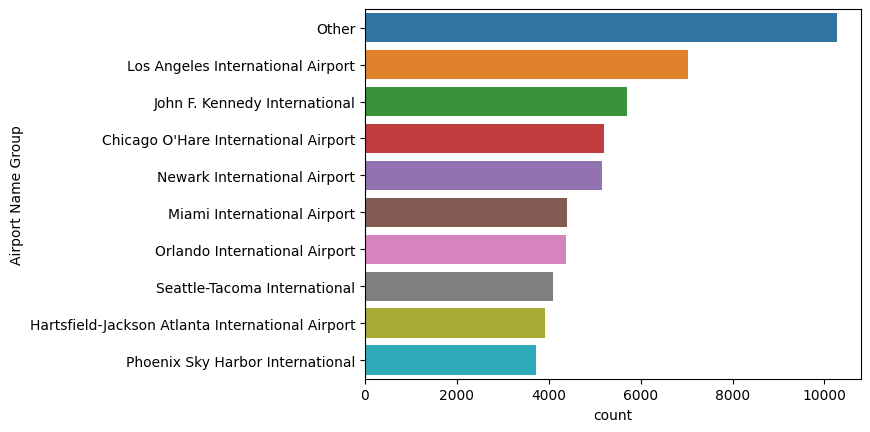

In [ ]:
# plotting
snis.barplot(data=dfb_airport.head(10), x='count', y='Airport Name Group')
mpl.show()

Pengaduan terjadi paling banyak selain others terletak pada pada Los Angeles International airport, dari data diatas dapat dikaitkan dengan data eksternal bahwa data yang memiliki pengaduan terbanyak merupakan bandara tersibuk di US. Sedangkan Other merupakan gabungan dari banyak bandara

sc: https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States

### 3.1.2 Cek tipe pengaduan

In [ ]:
# membuat dataframeberdasarkan pengaduan
dfb_klaim=dfb.groupby('Claim Type')[['Claim Number']].count().sort_values(by=['Claim Number'],ascending=False)

In [ ]:
dfb_klaim.reset_index(inplace=True)

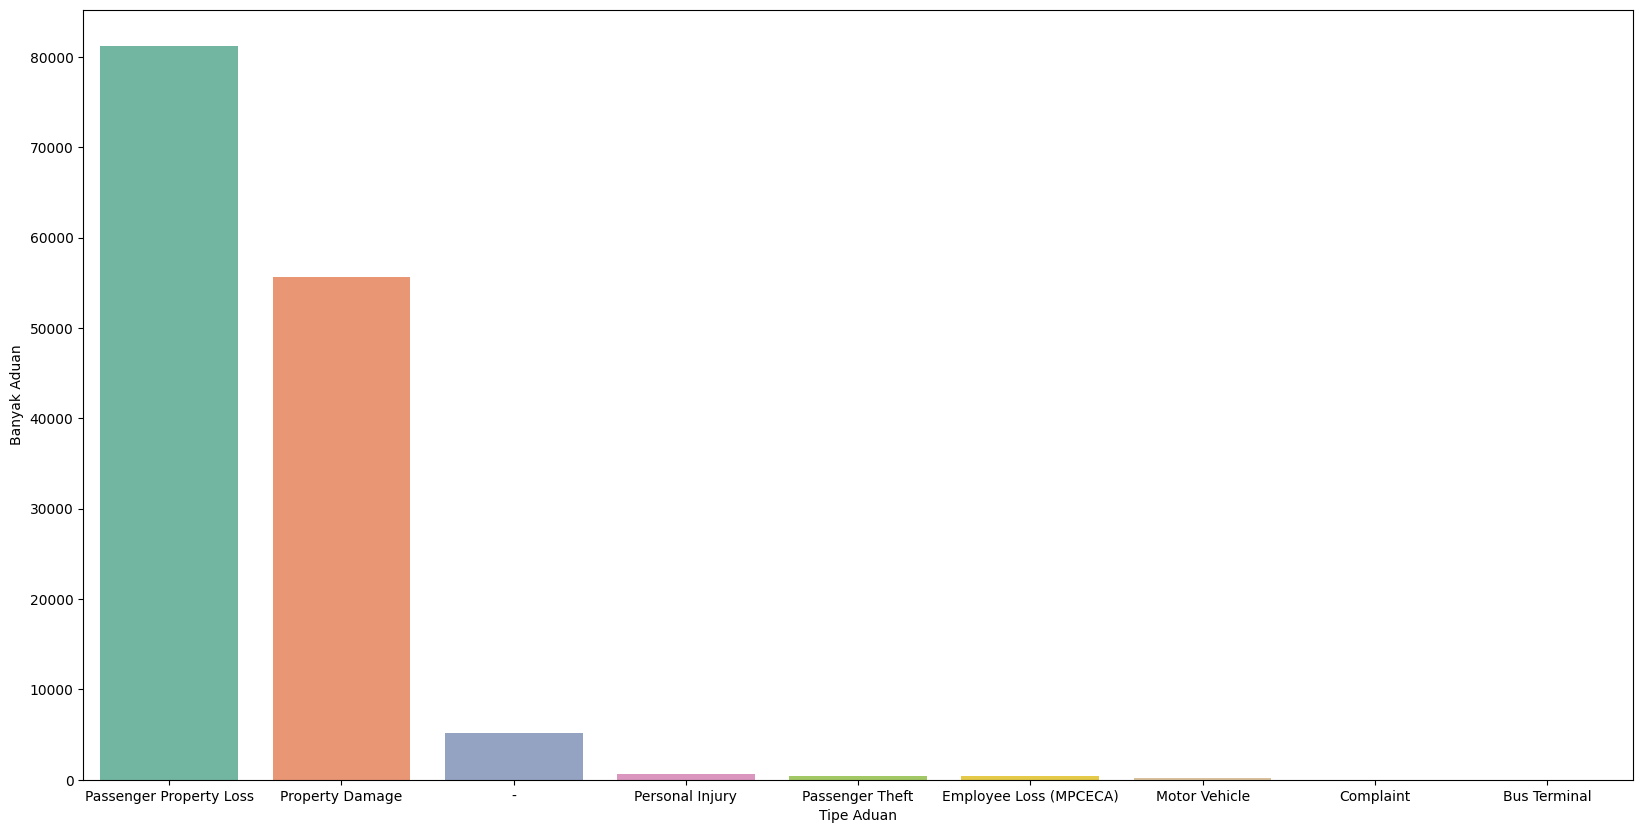

In [ ]:
# plotting berdasarkan tipe aduan
mpl.figure(figsize=(20,10))
snis.barplot(data=dfb_klaim,x='Claim Type',y='Claim Number',palette='Set2')
mpl.xlabel('Tipe Aduan')
mpl.ylabel('Banyak Aduan')
mpl.show()

Kehilangan dan kerusakan merupakan tipe pengaduan paling sering, hal ini disebabkan karena salah satu tugas harian TSA adalah melakukan pencarian dan pemeriksaan barang yang dibawa oleh penumpang

sc: https://jobs.tsa.gov/transport-security-officer#:~:text=Apply%20Now-,Job%20Description,or%20impacts%20our%20transportation%20systems.

### 3.1.3 Lokasi Pengaduan

In [ ]:
dfb_site = dfb.groupby('Claim Site', as_index=False)['Claim Site'].value_counts()
dfb_site = dfb_site.sort_values(by='count', ascending=False)
dfb_site

,Claim Site,count
2,Checked Baggage,114084
3,Checkpoint,28152
5,Other,944
4,Motor Vehicle,263
0,-,251
1,Bus Station,2


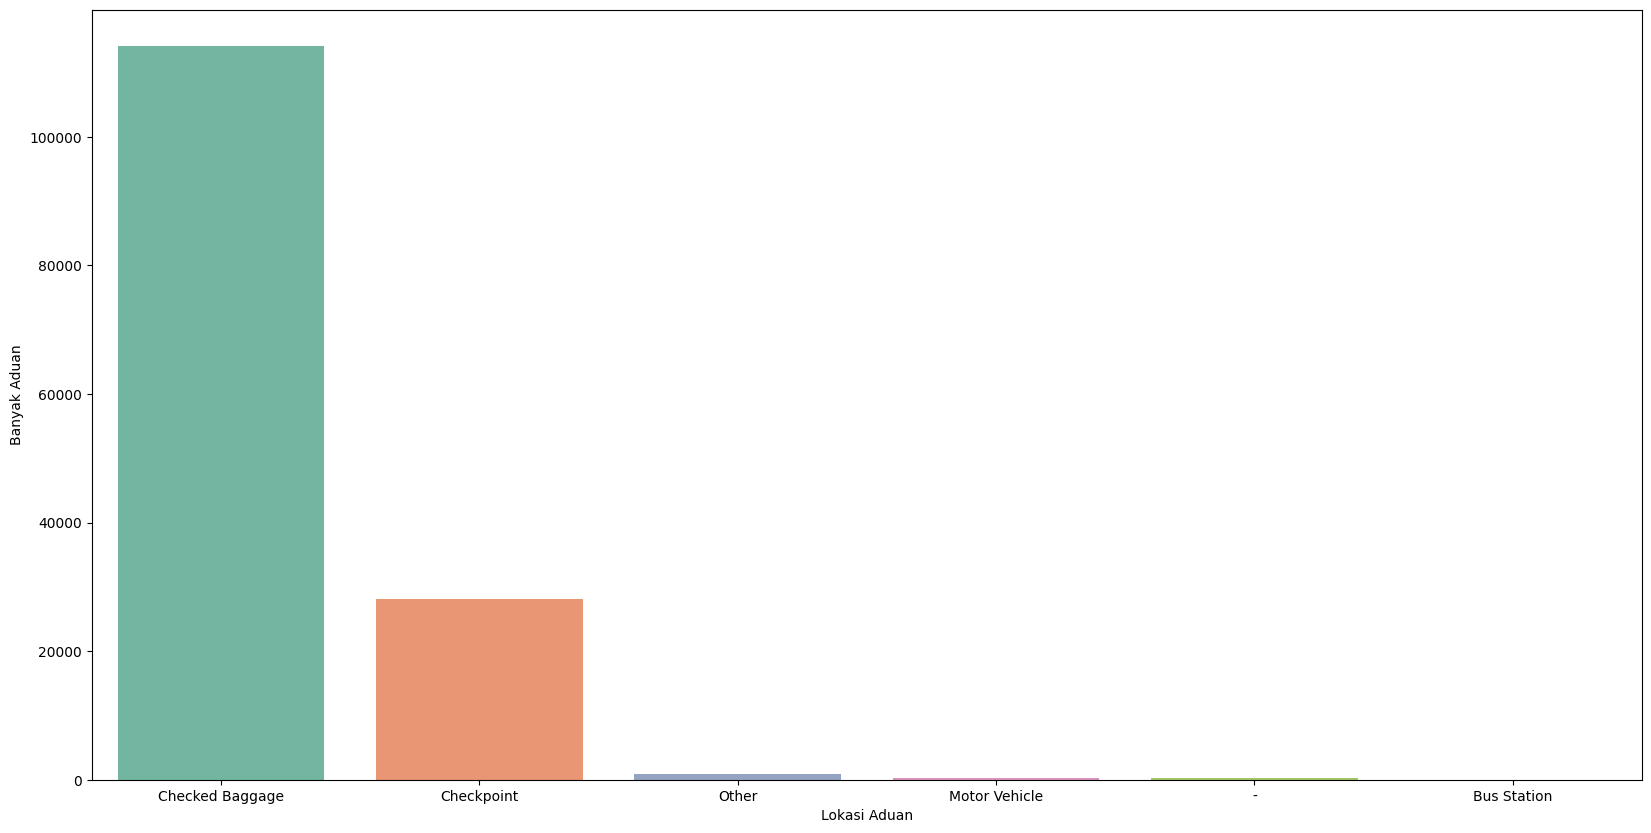

In [ ]:
# plotting berdasarkan lokasi
mpl.figure(figsize=(20,10))
snis.barplot(data=dfb_site,x='Claim Site',y='count',palette='Set2')
mpl.xlabel('Lokasi Aduan')
mpl.ylabel('Banyak Aduan')
mpl.show()

Pengaduan paling banyak dilaporkann di checked baggage, checked baggage adalah lokasi dimana penumpang melakukan check in penerbangan dan menyerahkan isi bagasi, dari diatas kita dapat berasumsi masakapai ikut bertanggung jawab atas aduan.

sc:https://www.flypgs.com/en/travel-glossary/checked-baggage

In [ ]:
dfb['Claim Type'].unique()

array(['-', 'Passenger Property Loss', 'Personal Injury',
       'Property Damage', 'Motor Vehicle', 'Passenger Theft',
       'Employee Loss (MPCECA)', 'Bus Terminal', 'Complaint'],
      dtype=object)

In [ ]:
aduan=['Passenger Property Loss','Property Damage']
aduan_filter=dfb[dfb['Claim Type'].isin(aduan)]

In [ ]:
# Menampilkan data yang memiliki aduan property loss dan property damage
aduan_filter

,Claim Number,Airline Name,Claim Type,Claim Site,Item,Status,Date Received,Incident Date,Airport Code Group,Airport Name Group,Claim Value,Close Value,Day Range
1,2.0041E+12,-,Passenger Property Loss,Checkpoint,Jewelry - Fine,Denied,6/25/2002,5/4/2002,ATL,Hartsfield-Jackson Atlanta International Airport,4457.29,0.00,52
6,0714534M,NorthwestAirlines,Property Damage,Other,Photographic Film,Denied,7/22/2002,3/6/2002,-,-,68.00,0.00,138
7,16410,DeltaAirLines,Passenger Property Loss,Checkpoint,Luggage (all types including footlockers),Settled,7/24/2002,7/10/2002,SDF,Louisville International,600.00,337.40,14
9,0702564M,AmericaWest,Property Damage,Checkpoint,Eyeglasses - (including contact lenses),Settled,8/19/2002,6/22/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,354.93,301.69,58
10,16759,SouthwestAirlines,Passenger Property Loss,Checkpoint,Other,Approved,8/21/2002,7/12/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,21.44,21.00,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143691,2015010000000.0,SouthwestAirlines,Property Damage,Checked Baggage,Computer & Accessories,Approved,12/31/2014,12/8/2014,FLL,Ft. Lauderdale-Hollywood International,800.00,800.00,23
143692,2015010000000.0,UAL,Property Damage,Checkpoint,Personal Accessories,Approved,12/31/2014,12/14/2014,SEA,Seattle-Tacoma International,50.00,50.00,17
143693,2014120000000.0,UAL,Property Damage,Checked Baggage,-,Approved,12/31/2014,12/26/2014,CLT,Charlotte/Douglas International Airport,24.95,24.95,5
143694,2014120000000.0,DeltaAirLines,Passenger Property Loss,Checked Baggage,Travel Accessories,Approved,12/31/2014,12/29/2014,DTW,Detroit Metropolitan Wayne County Airport,10.00,10.00,2


In [ ]:
SitexType=pd.crosstab(index=aduan_filter['Claim Site'],columns=aduan_filter['Claim Type']).sort_values(by='Passenger Property Loss',ascending=False)

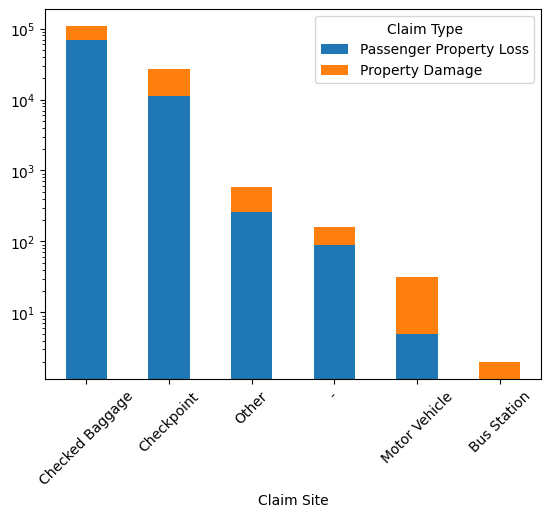

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# menampilkan plot
SitexType.plot(kind='bar',
      stacked=True)
mpl.xticks(rotation=45)
mpl.yscale('log')
mpl.figure(figsize=(20,10))

mpl.show()

Pengaduan paling sering terjadi pada sesi checked baggage dan jenis laporan adalah kehilangan barang. karena paling banyak di checked baggage, maka dapat diasumsikan bahwa maskapai bertanggung jawab sebagian atas masalah, karena pada sesi checked baggage penumpang menyerahkan barang yang akan diangkut kedalam bagasi.

### 3.1.4 Maskapai yang paling banyak menerima pengaduan

In [ ]:
dfb[dfb['Airline Name']!='-']

,Claim Number,Airline Name,Claim Type,Claim Site,Item,Status,Date Received,Incident Date,Airport Code Group,Airport Name Group,Claim Value,Close Value,Day Range
0,12772,SouthwestAirlines,-,Checkpoint,Clothing - Shoes; belts; accessories; etc.,Approved,6/20/2002,5/9/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,75.00,75.00,42
2,14460,AmericanAirlines,-,Checkpoint,Eyeglasses - (including contact lenses),Approved,7/8/2002,6/12/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,16.71,17.00,26
3,15242,AmericanAirlines,-,Other,Luggage (all types including footlockers),Denied,7/12/2002,5/31/2002,BWI,Baltimore/Washington Intl Thurgood Marshall,200.00,0.00,42
6,0714534M,NorthwestAirlines,Property Damage,Other,Photographic Film,Denied,7/22/2002,3/6/2002,-,-,68.00,0.00,138
7,16410,DeltaAirLines,Passenger Property Loss,Checkpoint,Luggage (all types including footlockers),Settled,7/24/2002,7/10/2002,SDF,Louisville International,600.00,337.40,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
143691,2015010000000.0,SouthwestAirlines,Property Damage,Checked Baggage,Computer & Accessories,Approved,12/31/2014,12/8/2014,FLL,Ft. Lauderdale-Hollywood International,800.00,800.00,23
143692,2015010000000.0,UAL,Property Damage,Checkpoint,Personal Accessories,Approved,12/31/2014,12/14/2014,SEA,Seattle-Tacoma International,50.00,50.00,17
143693,2014120000000.0,UAL,Property Damage,Checked Baggage,-,Approved,12/31/2014,12/26/2014,CLT,Charlotte/Douglas International Airport,24.95,24.95,5
143694,2014120000000.0,DeltaAirLines,Passenger Property Loss,Checked Baggage,Travel Accessories,Approved,12/31/2014,12/29/2014,DTW,Detroit Metropolitan Wayne County Airport,10.00,10.00,2


In [ ]:
maskapai=dfb[(dfb['Airline Name']!='-')&(dfb['Claim Site']=='Checkpoint')]

In [ ]:
# Melihat maskapai yang mempunyai pengaduan barang hilang pada baggage check
maskapai2=maskapai.groupby('Airline Name', as_index=False)['Airline Name'].value_counts()
maskapai2=maskapai2.sort_values(by='count', ascending=False)

,Airline Name,count
48,DeltaAirLines,2998
25,AmericanAirlines,2852
109,SouthwestAirlines,2820
122,UAL,1980
124,USAir,1715
...,...,...
73,KuwaitAirlines,1
16,AirPortugal,1
32,BahamaAirlines,1
112,SunWingAirlines,1


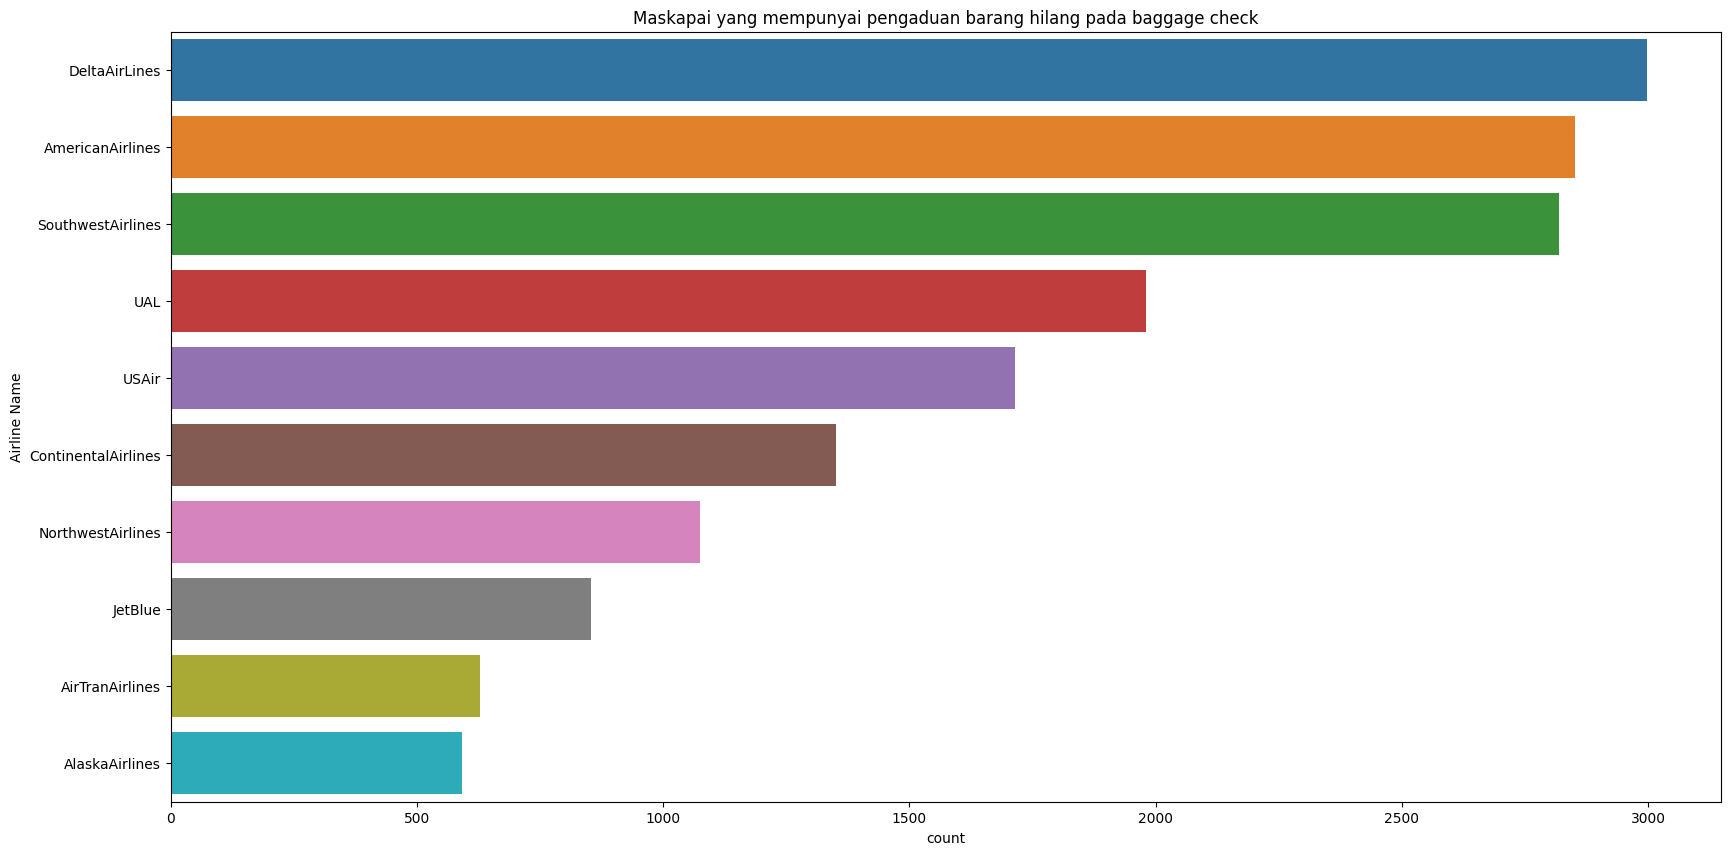

In [ ]:
mpl.figure(figsize=(20,10))
snis.barplot(data=maskapai2.head(10), x='count', y='Airline Name')
mpl.title('Maskapai yang mempunyai pengaduan barang hilang pada baggage check')
mpl.show()

Delta air,american airline, dan southwest airline memiliki nilai pengaduan paling banyak. ini dikarenakan maskapai penerbangan tersebut merupakan salah satu maskapai terbesar di US
sc: https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America

## 3.2 Faktor yang mempengaruhi keputusan TSA

### 3.2.1 Hasil Keputusan TSA

In [ ]:
dfb_status = dfb.groupby('Status', as_index=False)['Status'].value_counts()
dfb_status = dfb_status.sort_values(by='count', ascending=False)
dfb_status

,Status,count
1,Denied,67027
0,Approved,44671
2,Settled,31998


In [ ]:
fig=px.pie(dfb_status,
           names='Status',
           values='count',
           title='Persentase Status')
fig.show()

Hasil pengaduan paling banyak adalah ditolak, ada beberapa faktor yang mempengaruhi ditolaknya laporan baik yang ada pada data ataupun tidak, selanjutnya akan menjelaskan faktor yang mempengaruhi berdasarkan dataset

### 3.2.2 Cek berdasarkan Waktu

In [ ]:
dfb_claim=dfb.sort_values(by='Day Range')

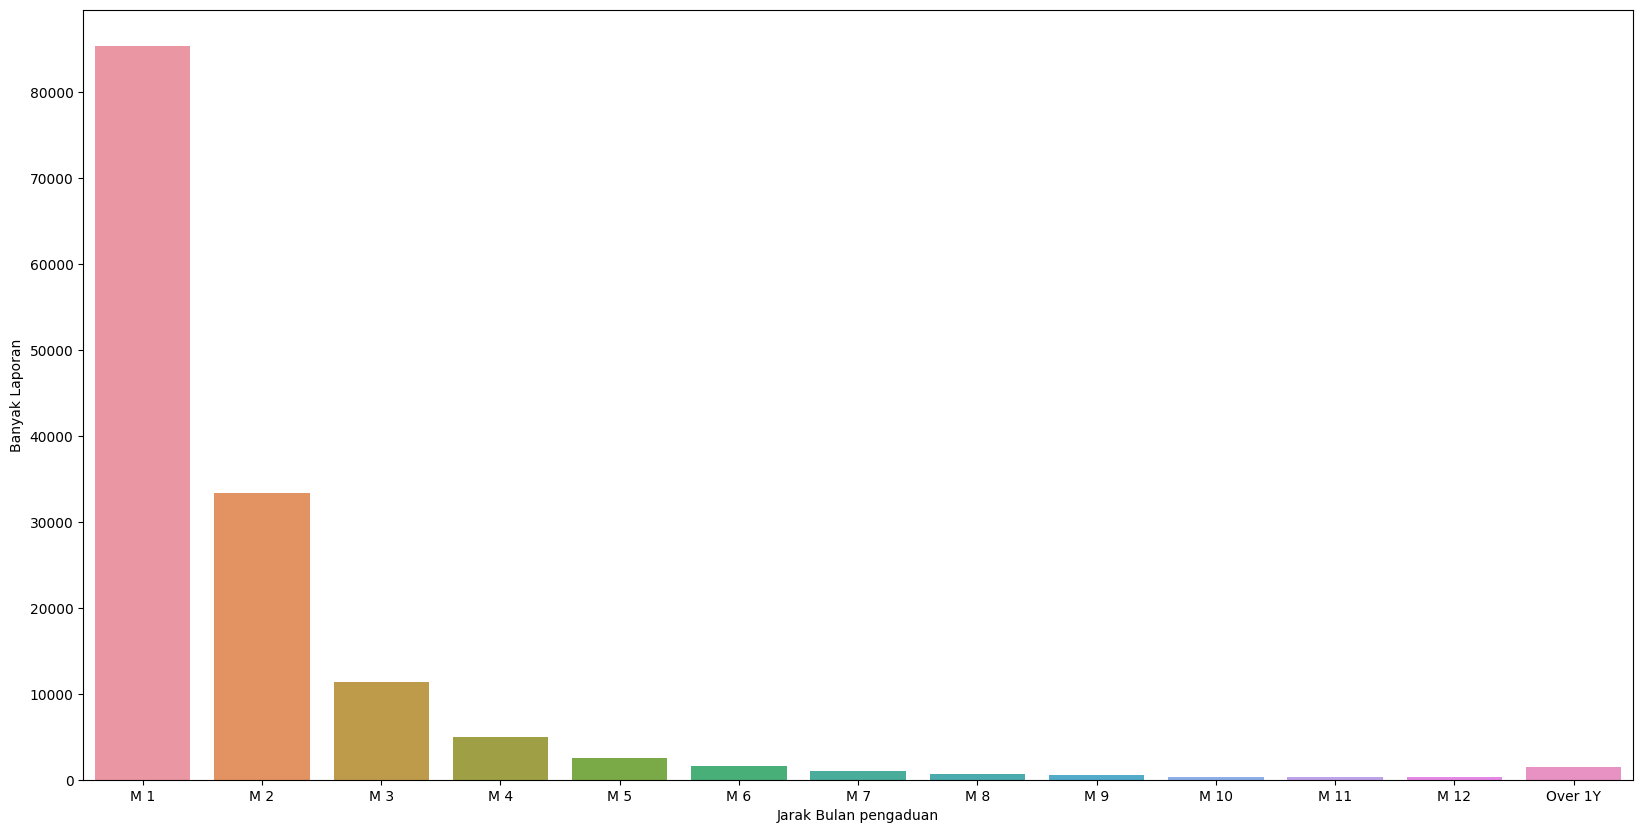

In [ ]:
# Grafik laporan berdasarkan bulan
mpl.figure(figsize=(20,10))
snis.countplot(data=dfb_claim,x='Month Range')
mpl.xlabel('Jarak Bulan pengaduan')
mpl.ylabel('Banyak Laporan')
mpl.show()

pengaduan paling banyak dilakukan pada bulan pertama setelah kejadian. Sedangkan semakin lama semakin sedikit yang melakukan pengaduan. karena semakin dekat rentang waktunya maka pengumpulan informasi akan lebih mudah

In [ ]:
dfb_claim2=dfb_claim[dfb_claim['Month Range']=='M 1']

Text(0, 0.5, 'Banyak Laporan')

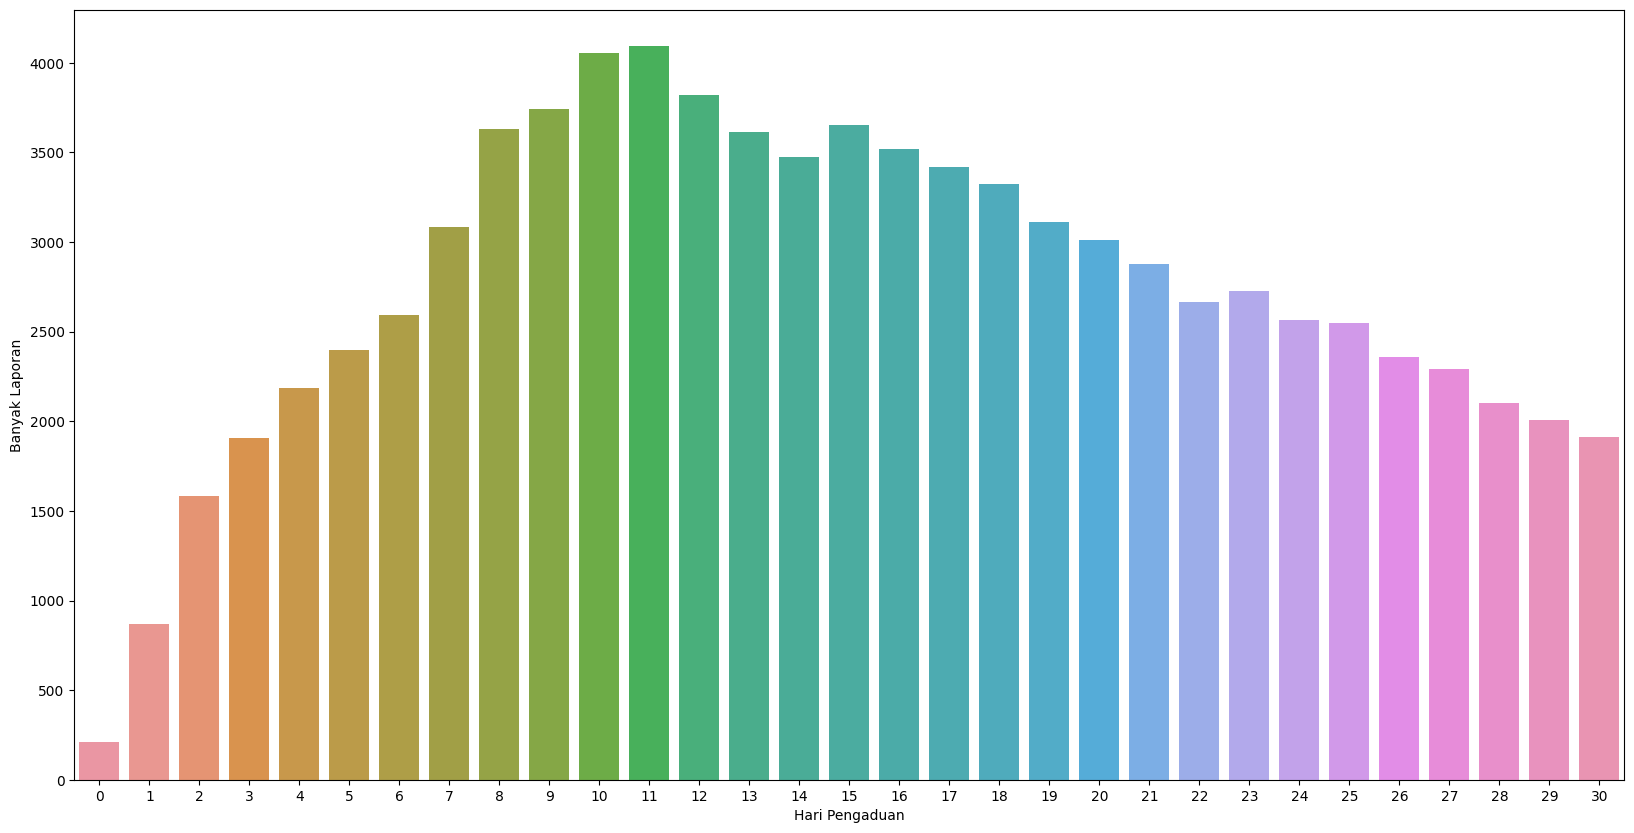

In [ ]:
# Grafik berdasarkan hari pada bulan ke 1
mpl.figure(figsize=(20,10))
snis.countplot(data=dfb_claim2,x='Day Range')
mpl.xlabel('Hari Pengaduan')
mpl.ylabel('Banyak Laporan')

Laporan paling banyak diterima pada hari ke-11 setelah kejadian. sesuai pernyataan TSA, pengaduan dalam kurun waktu 14 dari kejadian akan langsung ditanggapi.
sc: https://www.tsa.gov/sites/default/files/crdi-eeo-complaint-process.pdf 

In [ ]:
dfb_klaim3=pd.crosstab(index=dfb['Month Range'],columns=dfb['Status']).sort_index()

In [ ]:
dfb_klaim3

Status,Approved,Denied,Settled
Month Range,,,
M 1,26532,40378,18448
M 10,105,201,68
M 11,93,141,63
M 12,81,179,63
M 2,10792,14731,7843
M 3,3559,5137,2663
M 4,1422,2344,1179
M 5,709,1206,559
M 6,426,800,362


<Figure size 2000x1000 with 0 Axes>

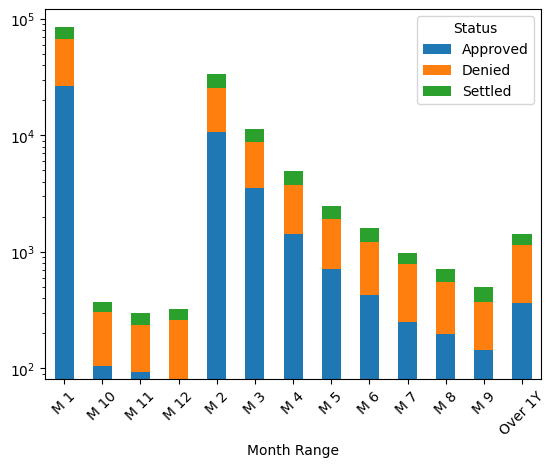

In [ ]:
# menampilkan hasil status berdasarkan bulan
mpl.figure(figsize=(20,10))
dfb_klaim3.plot(kind='bar',
      stacked=True)
mpl.xticks(rotation=45)
mpl.yscale('log')
mpl.show()

dari grafik diatas dapat disimpulkan bahwa semakin dekat jarak laporan ke kejadian, maka semakin tinggi kesempatan untuk pengaduan diterima oleh TSA

### 3.2.3 Cek Berdasarkan Claim Value

In [ ]:
# Membuat kolom price grouping
price = []
for i in dfb['Claim Value'] :
    if i > 0 and i <= 50 :
        price.append('Under 50 USD')
    elif i >=51  and i <= 100 :
        price.append ('Under 100 USD')
    elif i >=101  and i <= 250 :
        price.append ('Under 250 USD')
    elif i >=251  and i <= 500 :
        price.append ('Under 500 USD')
    elif i >=501  and i <= 1000 :
        price.append ('Under 1000 USD')
    elif i >1000 :
        price.append ('Over 1000 USD')
    else:
        price.append ('Other Ammount')
        
dfb['Price Range'] = price

In [ ]:
dfb_price=pd.crosstab(index=dfb['Price Range'],columns=dfb['Status']).sort_values(by='Approved',ascending=False)

<Figure size 2000x1000 with 0 Axes>

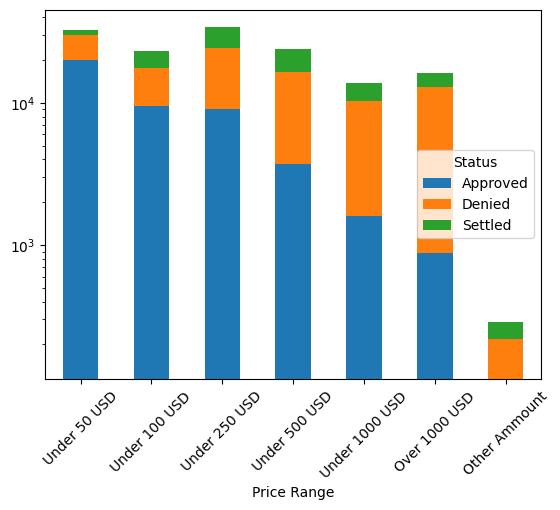

In [ ]:
# menampilkan hasil harga
mpl.figure(figsize=(20,10))
dfb_price.plot(kind='bar',
      stacked=True)
mpl.xticks(rotation=45)
mpl.yscale('log')
mpl.show()

Dari grafik diatas, nilai claim dibawah 50 USD paling memungkinkan untuk di Approved. dapat kita asumsikan bahwa nilai klaim dibawah 50 USD akan lebih mudah diganti karena perusahaan bisa saja langsung memberikan ganti tanpa harus membutuhkan sumber daya untuk melakukan investigasi lebih lanjut.

# 3. Kesimpulan dan Saran

1. Kesimpulan
    1. Semakin tinggi penumpang suatu bandara, maka semakin banyak juga jumlah pengaduan, begitu juga dengan maskapai penerbangan, semakin sering maskapai melakukan penerbangan, maka semakin besar juga laporan
    1. Tipe laporan paling terjadi adalah kehilangan barang dan kerusakan barang dan berlokasi pada Checked Baggage dan checkpoint. dapat diasumsikan pada kehilangan dan kerusakan barang, maskapai juga ikut andil tanggung jawab. karena lokasi checked baggage adalah lokasi dimana penumpang melakukan check in penerbangan dan menyerahkan barang yang akan dimuat ke bagasi,Sedangkan checkpoint adalah lokasi dimana barang diperiksa atau security check.
    1. TSA lebih banyak menolak pengaduan dibanding menerima(Approved) atau mengganti sebagian(Settled). ini disebabkan beberapa faktor seperti jarak laporan dan kejadian yang terlalu jauh atau nilai yang terlalu besar
    1. Jarak pengaduan paling banyak dilakukan dalam bulan pertama setelah kejadian, ini menandakan bahwa penumpang segera melakukan laporan setelah insiden terjadi
    1. Semakin rendah jarak antara laporan dan kejadian meningkatkan keputusan pengaduan diterima, karena pihak TSA dapat lebih mudan untuk melakukan investigasi dan menghemat sumber daya dan sebelum 'trail goes cold'
    1. Nilai claim paling banyak sekitar 250 USD, tetapi yang paling banyak diterima adalah nilai dibawah 50 USD, dapat diasumsikan bahwa degan nilai yang tergolong kecil, maka keputusan akan lebih mudah dilakukan

1. Saran 
    1. Pihak maskapai agar menyarankan penumpang yang akan menyerahkan barang bagasinya pada saat check in untuk diperiksa ulang atau jika perlu penumpang dianjurkan membuat list pribadi apa yang dibawa sehingga memudahkan pengecekan jika terjadi insiden
    1. Pihak bandara agar lebih sigap jika melihat barang tanpa pemilik dan langsung melaporkan nya sesuai area pada bandara.
        misal: jika menemukan barang di area setelah check in, maka diserahkan kepada bagian depature security check, jika di area terminal keberangkatan sebelum check in maka diserahkan ke pusat informasi terdekat
    1. Setelah kedatangan, maskapai disarankan berkoordinasi dengan penumpang untuk pemeriksaan ulang terhadap barang bagasi yang diterima oleh penumpang
    1. Untuk analisis lebih lanjut, karena keterbatasan waktu dan kemampuan, diharap dapat menganalisa kolom 'Item'
